# <h1><b><i><center><font color="orange"><u>DeepLearning - RNN - LSTM</u></font></center></i></b></h1>
<br/>

## Professor: Victor Venites
## Data: 08/09/2020
## Aula: 15
## Escola Livre de IA

In [ ]:
%%html
<marquee style='width: 100%; color: blue;'><h1><b><i>Long Short-Term Memory</i></b></h1></marquee>

## <h1><b><i><font color="orange"><u>Base do LSTM</u></font></i></b></h1>
- Exploração de Dados
- Séries Temporais
- Perceptron
- RNN = Recurrent Neural NetWork
- Arquitetura de Software

## <h1><b><i><font color="orange"><u>LSTM, TensorFlow e BitCoin</u></font></i></b></h1>
- Base baixada do site do Kaggle e tratada para esta aula

https://www.kaggle.com/mczielinski/bitcoin-historical-data

## Setup do Ambiente

In [2]:
import pandas as pd
from pandas import read_csv
import numpy
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('fivethirtyeight')
# FiveThirtyEight -> Gráfico com várias séries ao mesmo tempo
# Função Mágica - Colocar comandos/resultados do MatPlot

## DataPrep - Base Histórica BitCoin
- Vamos utilizar esta base já tratada

In [13]:
BitCoin = pd.read_csv("BitCoin_2012_a_2020.04.22.csv", index_col = 0)
BitCoin.index = pd.to_datetime(BitCoin.index)
BitCoin.loc[:, "Close"] = [round(valor, 2) for valor in BitCoin["Close"].values]
BitCoin.head(3)
# Dados puros do Kaggle

,Close
DateTime,
2011-12-31,4.47
2012-01-01,4.68
2012-01-02,5.00


In [15]:
BitCoin.tail(3)

,Close
DateTime,
2020-04-20,7052.49
2020-04-21,6867.57
2020-04-22,6850.60


## Filtro das Colunas

## Iniciando Análises e Hipóteses
- Dividindo os dados entre treino e validação

In [16]:
Train = BitCoin.loc['2011-12-31':'2019-12-31'].copy() # Treino
test = BitCoin.loc['2020-01-01':'2020-04-22'].copy() # Teste

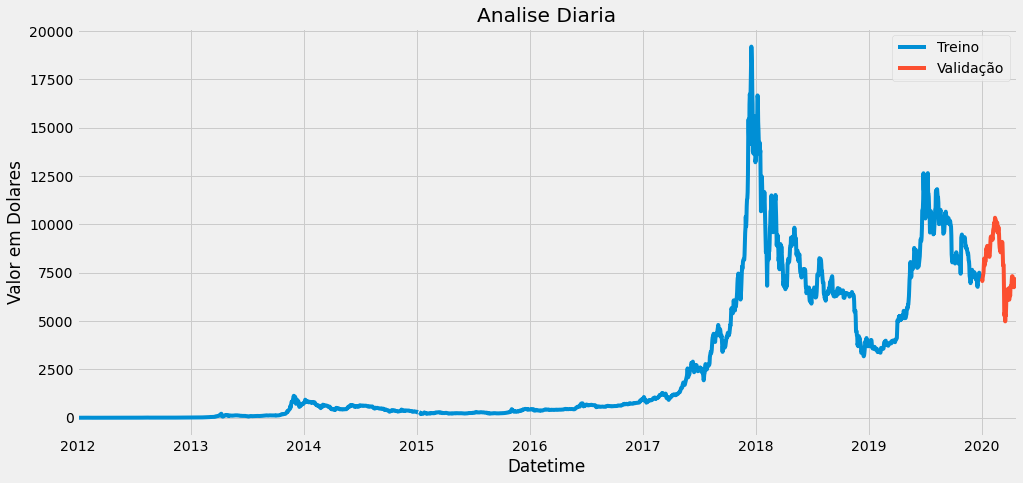

In [17]:
Train.Close.plot(figsize = (15,7), title = 'Analise Diaria', fontsize = 14, label = 'Treino')
test.Close.plot(figsize = (15,7), title = 'Analise Diaria', fontsize = 14, label = 'Validação')
plt.xlabel('Datetime')
plt.ylabel('Valor em Dolares')
plt.legend(loc = 'best')

## <h1><b><i><font color="orange"><u>LSTM e TensorFlow</u></font></i></b></h1>
- vamos executar com alguns Hyperparâmetros diferentes
## Vamos modelar uma regressão com LSTM

In [57]:
# Pacotes com Machine Learning
# Usa TensorFlow como backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import TimeDistributed

## Função de Separação do DataSet
- Cria vetores X e Y
- Variável LoopBack define quantidade de previsão Y

In [58]:
# Cria o DataSet para a Celula LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

## Função LSTM
- Criando uma função em Python com configurações pré-definidas para testar LSTM com Séries Temporais
- Permite testar alguns parametros diferentes e já imprime um gráfico

In [66]:
def do_lstm_model(df, 
                  Y, 
                  look_back = 2, 
                  Epocas = 2,
                  train_fraction = 0.90):

    # Semente do aleatório fixada
    numpy.random.seed(7)

    # Seta os dados
    dataset = df[Y].values
    dataset = dataset.astype('float32')

    # Normaliza para facilitar nos calculos,  entre 0 e 1
    scaler = MinMaxScaler(feature_range = (0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    # Separação entre Treino e Teste
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    Treino, Teste = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # Reshape para X=t e Y=t+1
    look_back = look_back
    TreinoX, TreinoY = create_dataset(Treino, look_back)
    testX, testY = create_dataset(Teste, look_back)
    TreinoX = numpy.reshape(TreinoX, (TreinoX.shape[0], 1, TreinoX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
    # Chama LSTM e treina a Rede
    batch_size = 1
    model = Sequential()
  
    model.add(LSTM(1, input_shape = (1, look_back)))
  
    #model.add(Dense(1))
    #model.add(TimeDistributed(Dense(1, activation='softmax')))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    model.fit(TreinoX, 
              TreinoY, 
              epochs = Epocas, 
              batch_size = 1, 
              verbose = 2)
  
    # Predizer os dados
    trainPredict = model.predict(TreinoX)
    print(trainPredict)
    testPredict = model.predict(testX)

    # Volta escapa original para Plotar
    trainPredict = scaler.inverse_transform(trainPredict)
    TreinoY = scaler.inverse_transform([TreinoY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
  
    # Calculo da Raiz do Erro Médio Quadrado (RMSE) e apresenta o resultado
    print(trainPredict)
    trainScore = math.sqrt(mean_squared_error(TreinoY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # Criando vetores de train e teste preditos para plotar
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # Código para plotar gráfico de resultados
    plt.figure(figsize=(15, 7))
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    plt.close()

    return

## Testando a Função LSTM com a base de dados BitCoin
- Teste para Regressão
- Veja 2 exemplos de Hyperparametros
- Mude os Parametros e veja qual melhor resultado para seu problema
- Pode substituir a base de BitCoin por outra
 - Ex: Chuva, Clientes, Pacientes, etc...

In [67]:
# Lembre-se LoopBack pequeno prevê bem a curto prazo, mas mal a longo prazo
# Por isso o modelo roda em Iterações contínuas de acordo com o tempo e a todo momento
do_lstm_model(df = BitCoin, 
              Y = 'Close', 
              look_back = 2, 
              Epocas = 5)

Epoch 1/5
 - 3s - loss: nan
Epoch 2/5
 - 3s - loss: nan
Epoch 3/5
 - 3s - loss: nan
Epoch 4/5
 - 3s - loss: nan
Epoch 5/5
 - 3s - loss: nan
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## LSTM para Regressão com janelas de tempo maiores
- LoopBack maior = 10
- Menos Épocas para realizar o BackPropagation neste LoopBack

In [22]:
do_lstm_model(df = BitCoin, 
              Y = 'Close', 
              look_back = 10, 
              Epocas = 2)

Epoch 1/2
 - 3s - loss: nan
Epoch 2/2
 - 3s - loss: nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').